<a href="https://colab.research.google.com/github/dmsroysillerico/MAE_M13_PUB/blob/main/Sprint2D_Churn_Olist_DRIVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sprint2D – Churn de Clientes Olist (Sprint 1 + Sprint 2 + Pipeline Mensual)

Notebook unificado para el proyecto de **Análisis de Churn** usando el dataset público de Olist (marketplace brasileño).

Este notebook integra en un solo flujo:

- **Sprint 1**  
  - Formulación del problema de negocio y del **MVP de churn**.  
  - EDA inicial sobre pedidos y clientes.  
  - Hipótesis de comportamiento de recompra.  
  - Construcción de una primera **tabla maestra** de órdenes.  
  - Definición del **target de churn preliminar** y KPIs base.

- **Sprint 2**  
  - Construcción de un **pipeline reproducible y modular**, parametrizado por período (`YYYY-MM`).  
  - **Data cleaning avanzado**: imputación de nulos y tratamiento de outliers (winsorización p1–p99).  
  - **Feature engineering** a nivel cliente: ~100 variables (RFM extendido, valor económico, logística de entrega, comportamiento de reviews, etc.).  
  - Definición del **target de churn final** a partir de la **distribución real de intervalos entre compras** (percentiles 90 y 99).  
  - Entrenamiento de modelos de clasificación (Regresión Logística y Random Forest) priorizando **recall sobre clientes churn**.  
  - **Selección de variables** usando correlación, Chi², ANOVA y feature importance del Random Forest (modelo full vs modelo reducido).  

- **Simulación mensual y persistencia**  
  - Simulación de incorporación de nuevos datos mediante una **fecha de corte mensual** (`FECHA_CORTE` = último día de cada mes).  
  - Generación de **snapshots mensuales** en formato Parquet:  
    - `orders_enriched_YYYY-MM.parquet` (master de órdenes)  
    - `customer_features_YYYY-MM.parquet` (features a nivel cliente)  
  - Registro histórico de KPIs de churn y métricas de modelo en `processed/metrics/kpis_churn_history.csv`.  
  - Función de **reset de snapshots** para reiniciar el flujo desde cero cuando sea necesario.



---


---



## Índice

1. **Introducción, problema de negocio y objetivo del MVP**  
2. **Configuración del entorno e imports**  
3. **Montaje de Google Drive (Colab) y definición de rutas**  
4. **Carga de datos Olist y descripción de tablas base**  
5. **EDA inicial (Sprint 1)**  
   - Rango temporal de órdenes  
   - Conteo de pedidos y clientes  
   - Valores faltantes en columnas clave  
   - Distribución de `order_status`  
6. **Parámetros del pipeline mensual**  
   - `PERIODO_OBJETIVO` (`YYYY-MM`)  
   - Cálculo de `FECHA_CORTE`  
7. **Funciones del pipeline (nivel orden)**  
   - Corte de datos por fecha (`cut_data_to_fecha_corte`)  
   - Construcción de `orders_enriched` (master de órdenes)  
   - Features de valor y tiempos logísticos por pedido  
8. **Master table por cliente y Feature Engineering**  
   - Agregación de órdenes a nivel `customer_unique_id`  
   - RFM extendido (Recency, Frequency, Monetary)  
   - Variables de comportamiento logístico (delays, tiempos entre hitos)  
   - Variables de reviews y estructura de compra (items, sellers, freight, etc.)  
   - Resultado: ~100 columnas (features numéricas + dummies de estado)

9. **Análisis de recencia y definición de umbrales de churn**  
   - Cálculo de `days_between_orders` para clientes con 2+ compras  
   - Estadísticos (mediana, IQR, percentiles 80–90–95–99, máximo)  
   - Definición **data-driven** de:  
     - `CHURN_PRELIM_THRESHOLD` (p.ej. percentil 90)  
     - `CHURN_FINAL_THRESHOLD` (p.ej. percentil 99)  

10. **Definición de targets de churn y KPIs de negocio**  
    - Construcción de `churn_prelim` y `churn_final`  
    - Cálculo de KPIs: churn rate, retention rate, gasto promedio total / activos / churn  

11. **Data cleaning avanzado en customer_features**  
    - Imputación de nulos numéricos con mediana / 0  
    - Imputación de nulos categóricos (`customer_state`)  
    - Tratamiento de outliers numéricos (winsorización p1–p99)  
    - Resumen de nulos y valores recortados  

12. **Preparación de datos para modelado y análisis de correlaciones**  
    - Construcción de `X` (features numéricas + dummies de `customer_state`)  
    - Construcción de `y` (`churn_final`)  
    - Correlaciones con el target  

13. **Selección de variables (Corr, Chi², ANOVA, Random Forest)**  
    - Ranking de features por:  
      - |correlación| con `churn_final`  
      - Chi²  
      - ANOVA F-test  
      - Importancia del Random Forest  
    - Definición **automática** de un subconjunto de features seleccionadas  
    - Construcción de `X_full` vs `X_reduced` y comparación de métricas  

14. **Modelos de clasificación**  
    - Regresión Logística (modelo full y reducido)  
    - Random Forest (modelo full)  
    - Métricas: accuracy, F1 para clase churn, ROC–AUC  

15. **Métricas de negocio y pruebas Chi² / ANOVA**  
    - Interpretación de KPIs de churn y retención  
    - Variables con mayor poder explicativo (logística, recency, estructura de compra)  

16. **Función `run_monthly_pipeline()` y persistencia de snapshots**  
    - Llamada parametrizada por `PERIODO_OBJETIVO` (ej. 2018-06, 2018-07, 2018-08)  
    - Generación automática de Parquets (`master` y `features`)  
    - Actualización del histórico de KPIs y métricas de modelos  
    - Validación para evitar reprocesar períodos ya corridos  

17. **Reset de resultados procesados (`reset_processed_outputs`)**  
    - Limpieza de carpetas `master/`, `features/` y `metrics/`  
    - Uso cuando se quiere recomenzar la simulación desde cero  

18. **Notas finales para Git y storytelling**  
    - Qué archivos versionar  
    - Cómo explicar el pipeline y los resultados en la exposición


---


---



## 1. Introducción, problema de negocio y objetivo del MVP

### 1.1 Contexto de negocio

- **Dominio**: Marketplace Olist (Brasil), donde múltiples vendedores (sellers) ofertan productos a clientes finales en todo el país.  
- **Datos disponibles**: transacciones históricas (órdenes, items, pagos, reviews, logística, clientes, sellers, etc.) a lo largo de ~2 años.  
- **Unidad de análisis para churn**: **cliente final**, identificado por `customer_unique_id` (un cliente puede tener varias órdenes en el tiempo).

---

### 1.2 Problema de negocio

Desde el punto de vista comercial, Olist necesita responder de forma mensual a la pregunta:

> **“¿Qué clientes tienen alto riesgo de abandono (churn) y deberían ser priorizados en campañas de retención?”**

Algunos comportamientos que pueden anticipar churn:

- **Alta recencia**: mucho tiempo desde la última compra.  
- **Experiencias logísticas negativas**: retrasos en la entrega, alta proporción de órdenes con demora.  
- **Percepción del servicio**: bajas calificaciones en reviews o alta variabilidad en las mismas.  
- **Baja frecuencia de compra** y poca “vida útil” como cliente.

En resumen, el objetivo no es solo medir quién ya se fue, sino **detectar a tiempo** a quienes están en la zona de riesgo para actuar antes de que abandonen definitivamente.

---

### 1.3 Definición operativa de churn

En este proyecto se define churn de forma **data-driven**, usando la distribución real de **intervalos entre compras**:

1. Se calculan los días entre compras (`days_between_orders`) para clientes con **2 o más órdenes**.  
2. Se analizan cuantitativamente sus estadísticos (mediana, IQR, percentiles 80/90/95/99, máximo).  
3. A partir de esa distribución se definen dos umbrales:

   - **Umbral de pre-churn** (`CHURN_PRELIM_THRESHOLD`):  
     días de recencia por encima del **percentil 90** de `days_between_orders`.  
     → Clientes que ya están “ más lejos de lo normal” y entran a zona de riesgo.

   - **Umbral de churn final** (`CHURN_FINAL_THRESHOLD`):  
     días de recencia por encima del **percentil 99** de `days_between_orders`.  
     → Clientes que están en la cola extrema de la distribución y se consideran **prácticamente perdidos**.

Con estos umbrales se construyen dos targets:

- `churn_prelim`: indicador de **riesgo** (zona amarilla).  
- `churn_final`: indicador de **churn consolidado** (zona roja, cliente casi seguro perdido).

Estos valores **no están quemados** (no son “90 días porque sí”), sino que provienen de la **historia real de recompra** de Olist y pueden recalcularse si se incorpora más data.

---

### 1.4 Objetivo del MVP

El **MVP de churn** consiste en un pipeline que, para cada período objetivo (`PERIODO_OBJETIVO = YYYY-MM`):

1. **Recibe los datos transaccionales de Olist** y los recorta hasta una **fecha de corte mensual** (`FECHA_CORTE` = último día del mes).  
2. Construye una **master table de órdenes** (`orders_enriched`), combinando:  
   `orders` + `customers` + `order_items` + `order_payments` + `order_reviews`, con features de valor, cantidad y tiempos logísticos por pedido.  
3. Agrega esa información a nivel **cliente** (`customer_features`), generando del orden de **100 features**:
   - RFM extendido: `recency_days`, `frequency`, `monetary` (sum, mean, min, max, std, etc.).  
   - Tiempos entre hitos logísticos: compra → aprobación, aprobación → despacho, despacho → entrega, retrasos vs fecha estimada.  
   - Calidad percibida: reviews promedio, variabilidad de reviews.  
   - Estructura de compra: número de items, número de sellers, peso del freight vs precio del producto, etc.
4. Calcula de forma automática los **umbrales de recencia** y define los **targets de churn** (preliminar y final).  
5. Entrena al menos **dos modelos de clasificación** (Regresión Logística y Random Forest), dando prioridad al **recall sobre clientes churn**, para minimizar falsos negativos (churners no detectados).  
6. Calcula y guarda **KPIs de negocio** por mes:  
   - `churn_rate`, `retention_rate`.  
   - Gasto promedio de clientes activos vs churn.  
   - Métricas técnicas de los modelos (accuracy, F1 para clase churn, ROC–AUC).  
7. Persiste los resultados en formato **snapshot mensual**:
   - Parquets por período (`orders_enriched_YYYY-MM`, `customer_features_YYYY-MM`).  
   - Historial de KPIs y métricas en `kpis_churn_history.csv`.

Este MVP permite que, al llegar un nuevo mes, el equipo de negocio/CRM pueda:

- **Ejecutar el pipeline para el nuevo período**,  
- Actualizar automáticamente el listado de clientes en riesgo,  
- Ver la evolución del churn y la retención en el tiempo,  
- Y **entender qué factores (features) están más asociados al abandono** (recency, delays, etc.), apoyándose en los rankings de importancia y en los modelos entrenados.

---

### 1.5 Hipótesis de negocio

Las siguientes hipótesis se formulan a partir del conocimiento del negocio de Olist y de la EDA inicial realizada sobre el histórico de pedidos:

1. **Hipótesis 1 – Recencia y churn**  
   A medida que aumenta el número de días desde la última compra del cliente (`recency_days`), **aumenta la probabilidad de churn**. Clientes que llevan mucho tiempo sin comprar son vistos por el negocio como inactivos o perdidos.

2. **Hipótesis 2 – Frecuencia y valor económico**  
   Clientes con **poca frecuencia de compra** (`frequency` baja) y **bajo valor económico total** (`order_value_sum` bajo) tienen **mayor riesgo de churn** que aquellos que compran más veces y con tickets mayores.

3. **Hipótesis 3 – Comportamiento de pago**  
   Clientes que realizan sus compras con **muchas cuotas** (`avg_installments` alta) y con **tickets promedio más bajos** (`order_value_mean` bajo) tienden a tener **mayor probabilidad de abandono**, porque son compras más esporádicas y de menor compromiso con la plataforma.

4. **Hipótesis 4 – Experiencia de entrega y satisfacción**  
   Peores experiencias logísticas y de servicio se asocian a churn. En particular:  
   - Mayores **retrasos de entrega** (`delivery_delay_days` positivos, `pct_delayed_orders` alto), y  
   - **Puntajes de review más bajos** (`avg_review_score` < 4)  
   se esperan **correlacionar positivamente con el churn**.

5. **Hipótesis 5 – Ubicación geográfica (customer_state)**  
   Determinados estados (`customer_state`) podrían presentar **tasas de churn sistemáticamente más altas** por temas logísticos (distancia, tiempos de entrega, disponibilidad de sellers), por lo que la localización del cliente puede ayudar a explicar el riesgo de abandono.

---

### 1.6 Métricas base del proyecto

En línea con el enunciado del caso de churn mensual, se definen dos grupos de métricas base:

- **Métricas técnicas del modelo (ML)**  
  - **Recall** sobre la clase positiva (churn), para priorizar la detección de clientes en riesgo.  
  - **F1-score**, para balancear precisión y recall.  
  - **ROC-AUC**, como medida global de capacidad discriminativa del modelo.

- **Métricas de negocio (KPIs)**  
  - **Churn rate mensual**: % de clientes que pasan a estado churn en un período.  
  - **Retention rate mensual**: % de clientes que se mantienen activos.  
  - **Gasto promedio por cliente**: ticket promedio de clientes activos vs. churn, para estimar el impacto económico de perder a un cliente.
  
---



## 2. Configuración del entorno e imports

In [23]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2, f_classif

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.4f}".format

print("Entorno listo.")


Entorno listo.


## 3. Montaje de Google Drive (Colab) y rutas de datos

In [24]:

    from google.colab import drive
    drive.mount('/content/drive')

    DATA_DIR = Path('/content/drive/MyDrive/Maestria/M13/Olist')

    print("Archivos encontrados para análisis:")
    for f in DATA_DIR.glob('*.csv'):
        print(" -", f.name)

    PROCESSED_DIR = DATA_DIR / 'processed'
    (PROCESSED_DIR / 'master').mkdir(parents=True, exist_ok=True)
    (PROCESSED_DIR / 'features').mkdir(parents=True, exist_ok=True)
    (PROCESSED_DIR / 'metrics').mkdir(parents=True, exist_ok=True)

    print("\nCarpetas de salida listas:")
    print(" -", PROCESSED_DIR / 'master')
    print(" -", PROCESSED_DIR / 'features')
    print(" -", PROCESSED_DIR / 'metrics')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivos encontrados para análisis:
 - olist_customers_dataset.csv
 - olist_geolocation_dataset.csv
 - olist_order_items_dataset.csv
 - olist_order_payments_dataset.csv
 - olist_orders_dataset.csv
 - olist_order_reviews_dataset.csv
 - olist_products_dataset.csv
 - olist_sellers_dataset.csv
 - product_category_name_translation.csv

Carpetas de salida listas:
 - /content/drive/MyDrive/Maestria/M13/Olist/processed/master
 - /content/drive/MyDrive/Maestria/M13/Olist/processed/features
 - /content/drive/MyDrive/Maestria/M13/Olist/processed/metrics


## 4. Carga de datos Olist y tablas base

In [25]:

def load_olist_data(data_dir: Path) -> dict:
    """Carga los CSV de Olist y devuelve un diccionario de DataFrames."""

    orders = pd.read_csv(
        data_dir / 'olist_orders_dataset.csv',
        parse_dates=[
            'order_purchase_timestamp',
            'order_approved_at',
            'order_delivered_carrier_date',
            'order_delivered_customer_date',
            'order_estimated_delivery_date'
        ]
    )
    customers = pd.read_csv(data_dir / 'olist_customers_dataset.csv')
    order_items = pd.read_csv(
        data_dir / 'olist_order_items_dataset.csv',
        parse_dates=['shipping_limit_date']
    )
    order_payments = pd.read_csv(data_dir / 'olist_order_payments_dataset.csv')
    order_reviews = pd.read_csv(
        data_dir / 'olist_order_reviews_dataset.csv',
        parse_dates=['review_creation_date', 'review_answer_timestamp']
    )
    products = pd.read_csv(data_dir / 'olist_products_dataset.csv')
    sellers = pd.read_csv(data_dir / 'olist_sellers_dataset.csv')
    geolocation = pd.read_csv(data_dir / 'olist_geolocation_dataset.csv')
    prod_cat_trans = pd.read_csv(data_dir / 'product_category_name_translation.csv')

    return {
        'orders': orders,
        'customers': customers,
        'order_items': order_items,
        'order_payments': order_payments,
        'order_reviews': order_reviews,
        'products': products,
        'sellers': sellers,
        'geolocation': geolocation,
        'prod_cat_trans': prod_cat_trans
    }

data = load_olist_data(DATA_DIR)

print("Tablas cargadas:\n")
for name, df in data.items():
    print(f"{name:15s}: {df.shape[0]:7d} filas x {df.shape[1]:2d} columnas")


Tablas cargadas:

orders         :   99441 filas x  8 columnas
customers      :   99441 filas x  5 columnas
order_items    :  112650 filas x  7 columnas
order_payments :  103886 filas x  5 columnas
order_reviews  :   99224 filas x  7 columnas
products       :   32951 filas x  9 columnas
sellers        :    3095 filas x  4 columnas
geolocation    : 1000163 filas x  5 columnas
prod_cat_trans :      71 filas x  2 columnas


## 5. EDA inicial (Sprint 1)

Rango temporal de `order_purchase_timestamp`:
  Mínimo: 2016-09-04 21:15:19
  Máximo: 2018-10-17 17:30:18
  Duración (días): 772

Número de pedidos y clientes:
  Pedidos totales: 99441
  Clientes (customer_id) únicos: 99441
  Clientes (customer_unique_id) únicos: 96096

Valores faltantes en orders:


,missing_count,missing_pct
order_delivered_customer_date,2965,2.9817
order_delivered_carrier_date,1783,1.7930
order_approved_at,160,0.1609



Distribución de `order_status`:


,count
order_status,
delivered,96478
shipped,1107
canceled,625
unavailable,609
invoiced,314
processing,301
created,5
approved,2


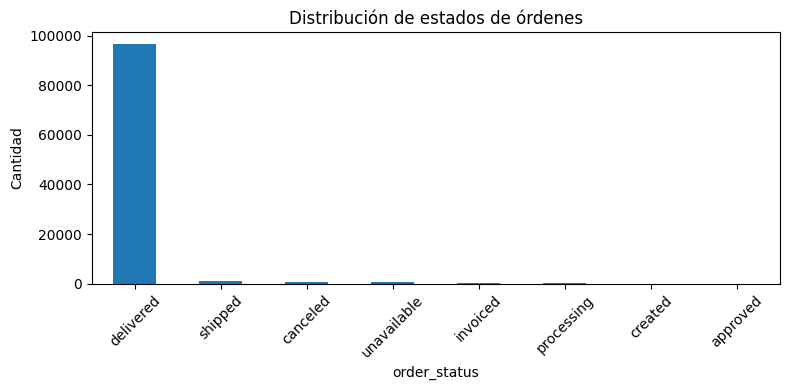

In [26]:

orders = data['orders']
customers = data['customers']

print("Rango temporal de `order_purchase_timestamp`:")
print("  Mínimo:", orders['order_purchase_timestamp'].min())
print("  Máximo:", orders['order_purchase_timestamp'].max())
print("  Duración (días):",
      (orders['order_purchase_timestamp'].max() - orders['order_purchase_timestamp'].min()).days)

print("\nNúmero de pedidos y clientes:")
print("  Pedidos totales:", len(orders))
print("  Clientes (customer_id) únicos:", orders['customer_id'].nunique())
print("  Clientes (customer_unique_id) únicos:", customers['customer_unique_id'].nunique())

def missing_values_table(df: pd.DataFrame, max_rows: int = 20):
    mv = df.isna().sum()
    mv = mv[mv > 0].sort_values(ascending=False)
    res = pd.DataFrame({
        'missing_count': mv,
        'missing_pct': mv / len(df) * 100
    })
    return res.head(max_rows)

print("\nValores faltantes en orders:")
display(missing_values_table(orders))

status_counts = orders['order_status'].value_counts().sort_values(ascending=False)
print("\nDistribución de `order_status`:")
display(status_counts)

plt.figure(figsize=(8, 4))
status_counts.plot(kind='bar')
plt.title('Distribución de estados de órdenes')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 6. Parámetros del pipeline mensual

In [27]:

PERIODO_OBJETIVO = "2018-06"  # YYYY-MM

periodo = pd.Period(PERIODO_OBJETIVO, freq='M')
FECHA_CORTE = periodo.to_timestamp('M')

print(f"PERIODO_OBJETIVO: {PERIODO_OBJETIVO}")
print(f"FECHA_CORTE: {FECHA_CORTE}")


PERIODO_OBJETIVO: 2018-06
FECHA_CORTE: 2018-06-30 00:00:00


## 7. Funciones del pipeline (limpieza, recorte, master de órdenes)

In [28]:

def clean_orders(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df[~df['order_purchase_timestamp'].isna()]
    return df

def clean_customers(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df.drop_duplicates(subset=['customer_id'])
    return df

def clean_order_items(df: pd.DataFrame) -> pd.DataFrame:
    return df.copy()

def clean_order_payments(df: pd.DataFrame) -> pd.DataFrame:
    return df.copy()

def clean_order_reviews(df: pd.DataFrame) -> pd.DataFrame:
    return df.copy()

def get_last_processed_period(features_dir: Path):
    pattern = 'customer_features_'
    files = list(features_dir.glob(f'{pattern}*.parquet'))
    if not files:
        return None
    periods = []
    for f in files:
        name = f.stem
        if pattern in name:
            periods.append(name.replace(pattern, ''))
    return max(periods) if periods else None

last_period = get_last_processed_period(PROCESSED_DIR / 'features')
print("Último período procesado encontrado:", last_period)

def cut_data_to_fecha_corte(data_dict: dict, fecha_corte: pd.Timestamp) -> dict:
    orders_all = clean_orders(data_dict['orders'])
    customers_all = clean_customers(data_dict['customers'])
    order_items_all = clean_order_items(data_dict['order_items'])
    order_payments_all = clean_order_payments(data_dict['order_payments'])
    order_reviews_all = clean_order_reviews(data_dict['order_reviews'])

    orders_cut = orders_all[orders_all['order_purchase_timestamp'] <= fecha_corte].copy()

    order_ids = orders_cut['order_id'].unique()
    customer_ids = orders_cut['customer_id'].unique()

    order_items_cut = order_items_all[order_items_all['order_id'].isin(order_ids)].copy()
    order_payments_cut = order_payments_all[order_payments_all['order_id'].isin(order_ids)].copy()
    order_reviews_cut = order_reviews_all[order_reviews_all['order_id'].isin(order_ids)].copy()
    customers_cut = customers_all[customers_all['customer_id'].isin(customer_ids)].copy()

    return {
        'orders': orders_cut,
        'customers': customers_cut,
        'order_items': order_items_cut,
        'order_payments': order_payments_cut,
        'order_reviews': order_reviews_cut
    }

data_cut = cut_data_to_fecha_corte(data, FECHA_CORTE)

print("Tamaños después de FECHA_CORTE:")
for name, df in data_cut.items():
    print(f"{name:15s}: {df.shape[0]:7d} filas x {df.shape[1]:2d} columnas")

def build_orders_enriched(orders, customers, order_items, order_payments, order_reviews):
    df = orders.merge(customers, on='customer_id', how='left')

    payments_agg = order_payments.groupby('order_id').agg(
        total_payment=('payment_value', 'sum'),
        avg_installments=('payment_installments', 'mean')
    ).reset_index()
    df = df.merge(payments_agg, on='order_id', how='left')

    reviews_agg = order_reviews.groupby('order_id').agg(
        avg_review_score=('review_score', 'mean'),
        n_reviews=('review_score', 'size')
    ).reset_index()
    df = df.merge(reviews_agg, on='order_id', how='left')

    items_agg = order_items.groupby('order_id').agg(
        n_items=('order_item_id', 'count'),
        n_sellers=('seller_id', 'nunique'),
        total_items_price=('price', 'sum'),
        total_freight_value=('freight_value', 'sum')
    ).reset_index()
    items_agg['order_value'] = items_agg['total_items_price'] + items_agg['total_freight_value']
    df = df.merge(items_agg, on='order_id', how='left')

    def days_diff(col_end, col_start):
        return (col_end - col_start).dt.total_seconds() / 86400

    df['purchase_to_approval_days'] = days_diff(df['order_approved_at'], df['order_purchase_timestamp'])
    df['approval_to_carrier_days'] = days_diff(df['order_delivered_carrier_date'], df['order_approved_at'])
    df['carrier_to_customer_days'] = days_diff(df['order_delivered_customer_date'], df['order_delivered_carrier_date'])
    df['delivery_delay_days'] = days_diff(df['order_delivered_customer_date'], df['order_estimated_delivery_date'])

    df_completed = df[df['order_status'] == 'delivered'].copy()
    return df_completed

orders_enriched = build_orders_enriched(
    data_cut['orders'],
    data_cut['customers'],
    data_cut['order_items'],
    data_cut['order_payments'],
    data_cut['order_reviews']
)

print("orders_enriched:", orders_enriched.shape)
display(orders_enriched.head())


Último período procesado encontrado: None
Tamaños después de FECHA_CORTE:
orders         :   86493 filas x  8 columnas
customers      :   86493 filas x  5 columnas
order_items    :   98170 filas x  7 columnas
order_payments :   90536 filas x  5 columnas
order_reviews  :   86325 filas x  7 columnas
orders_enriched: (83845, 25)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,n_reviews,n_items,n_sellers,total_items_price,total_freight_value,order_value,purchase_to_approval_days,approval_to_carrier_days,carrier_to_customer_days,delivery_delay_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,1.0000,1.0000,1.0000,29.9900,8.7200,38.7100,0.0074,2.3665,6.0627,-7.1075
1,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,1.0000,1.0000,1.0000,45.0000,27.2000,72.2000,0.0124,3.7458,9.4505,-12.9801
2,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,1.0000,1.0000,1.0000,19.9000,8.7200,28.6200,0.0429,0.8931,1.9378,-9.2382
3,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,...,1.0000,1.0000,1.0000,147.9000,27.3600,175.2600,0.0091,1.6999,14.8332,-5.5431
5,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,...,1.0000,1.0000,1.0000,59.9900,15.1700,75.1600,0.0081,5.8650,4.1167,-11.4612


## 8. Master table por cliente y Feature Engineering (100+ features)

In [29]:

def build_customer_features(orders_enriched: pd.DataFrame, fecha_corte: pd.Timestamp) -> pd.DataFrame:
    df = orders_enriched.copy()

    agg = df.groupby('customer_unique_id').agg({
        'order_purchase_timestamp': ['min', 'max', 'count'],
        'order_value': ['sum', 'mean', 'std', 'min', 'max', 'median'],
        'total_items_price': ['sum', 'mean', 'std', 'min', 'max'],
        'total_freight_value': ['sum', 'mean', 'std', 'min', 'max'],
        'n_items': ['sum', 'mean', 'std', 'min', 'max'],
        'n_sellers': ['sum', 'mean', 'std', 'min', 'max'],
        'total_payment': ['sum', 'mean', 'std', 'min', 'max'],
        'avg_installments': ['mean', 'std', 'min', 'max'],
        'avg_review_score': ['mean', 'std', 'min', 'max'],
        'n_reviews': ['sum', 'mean', 'max'],
        'purchase_to_approval_days': ['mean', 'std', 'min', 'max'],
        'approval_to_carrier_days': ['mean', 'std', 'min', 'max'],
        'carrier_to_customer_days': ['mean', 'std', 'min', 'max'],
        'delivery_delay_days': ['mean', 'std', 'min', 'max',
                                lambda x: (x > 0).sum(),
                                lambda x: (x < 0).sum()]
    }).reset_index()

    agg.columns = [
        '_'.join(col).strip('_') if isinstance(col, tuple) else col
        for col in agg.columns.values
    ]

    rename_map = {
        'order_purchase_timestamp_min': 'first_purchase_date',
        'order_purchase_timestamp_max': 'last_purchase_date',
        'order_purchase_timestamp_count': 'frequency',
        'delivery_delay_days_<lambda_0>': 'num_delayed_orders',
        'delivery_delay_days_<lambda_1>': 'num_early_orders'
    }
    customer_features = agg.rename(columns=rename_map)

    customer_features['recency_days'] = (
        fecha_corte - customer_features['last_purchase_date']
    ).dt.days

    customer_features['customer_lifetime_days'] = (
        customer_features['last_purchase_date'] - customer_features['first_purchase_date']
    ).dt.days

    customer_features['avg_days_between_orders'] = (
        customer_features['customer_lifetime_days'] / (customer_features['frequency'] - 1)
    )
    customer_features['avg_days_between_orders'] = (
        customer_features['avg_days_between_orders']
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0)
    )

    customer_features['pct_delayed_orders'] = (
        customer_features['num_delayed_orders'] / customer_features['frequency']
    ).fillna(0)

    customer_features['pct_early_orders'] = (
        customer_features['num_early_orders'] / customer_features['frequency']
    ).fillna(0)

    customer_features['freight_ratio_total'] = (
        customer_features['total_freight_value_sum'] /
        customer_features['order_value_sum']
    ).replace([np.inf, -np.inf], np.nan).fillna(0)

    customer_features['avg_price_per_item'] = (
        customer_features['total_items_price_sum'] /
        customer_features['n_items_sum']
    ).replace([np.inf, -np.inf], np.nan).fillna(0)

    state_series = (
        df.groupby('customer_unique_id')['customer_state']
          .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
    )
    customer_features = customer_features.merge(
        state_series.reset_index(),
        on='customer_unique_id',
        how='left'
    )

    print("Número total de variables (columnas):", customer_features.shape[1])
    return customer_features

customer_features = build_customer_features(orders_enriched, FECHA_CORTE)
print("customer_features:", customer_features.shape)
display(customer_features.head())


Número total de variables (columnas): 72
customer_features: (81147, 72)


,customer_unique_id,first_purchase_date,last_purchase_date,frequency,order_value_sum,order_value_mean,order_value_std,order_value_min,order_value_max,order_value_median,...,num_delayed_orders,num_early_orders,recency_days,customer_lifetime_days,avg_days_between_orders,pct_delayed_orders,pct_early_orders,freight_ratio_total,avg_price_per_item,customer_state
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,1,141.9000,141.9000,NaN,141.9000,141.9000,141.9000,...,0,1,50,0,0.0000,0.0000,1.0000,0.0846,129.9000,SP
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,1,27.1900,27.1900,NaN,27.1900,27.1900,27.1900,...,0,1,53,0,0.0000,0.0000,1.0000,0.3049,18.9000,SP
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,1,86.2200,86.2200,NaN,86.2200,86.2200,86.2200,...,0,1,476,0,0.0000,0.0000,1.0000,0.1997,69.0000,SC
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,1,43.6200,43.6200,NaN,43.6200,43.6200,43.6200,...,0,1,260,0,0.0000,0.0000,1.0000,0.4042,25.9900,PA
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,1,196.8900,196.8900,NaN,196.8900,196.8900,196.8900,...,0,1,227,0,0.0000,0.0000,1.0000,0.0858,180.0000,SP


## 8.1 Análisis del ciclo de recompra (intervalos entre compras)

Resumen de intervalos entre compras (solo clientes con 2+ órdenes):
  • Número de intervalos           : 2,698
  • Clientes con 2+ compras        : 2,421

Estadísticos de days_between_orders (en días):
  Q1 (25%)           :    0.0
  Mediana (50%)      :   24.0
  Q3 (75%)           :  108.0
  IQR (Q3 - Q1)      :  108.0
  Percentil 80       :  134.0
  Percentil 90       :  214.3
  Percentil 95       :  291.5
  Percentil 99       :  397.0
  Máximo observado   :  608.0


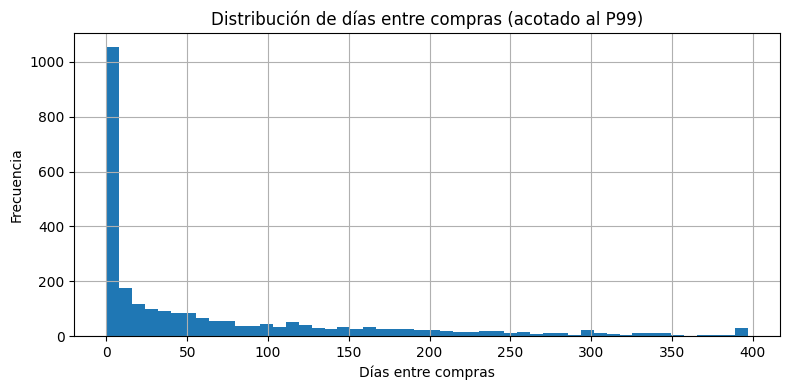

In [30]:
# 8.1 Cálculo de intervalos entre compras por cliente

# Usamos orders_enriched (solo órdenes entregadas hasta FECHA_CORTE)
df_intervals = orders_enriched[['customer_unique_id', 'order_purchase_timestamp']].copy()

# Ordenar por cliente y fecha de compra
df_intervals = df_intervals.sort_values(
    ['customer_unique_id', 'order_purchase_timestamp']
)

# Fecha de la siguiente compra por cliente
df_intervals['next_purchase_timestamp'] = (
    df_intervals
    .groupby('customer_unique_id')['order_purchase_timestamp']
    .shift(-1)
)

# Días entre una compra y la siguiente
df_intervals['days_between_orders'] = (
    df_intervals['next_purchase_timestamp'] - df_intervals['order_purchase_timestamp']
).dt.days

# Nos quedamos solo con intervalos válidos (no nulos y no negativos)
intervals = df_intervals.dropna(subset=['days_between_orders']).copy()
intervals = intervals[intervals['days_between_orders'] >= 0]

# Serie global que usaremos en el siguiente bloque
days_between_orders = intervals['days_between_orders']

n_intervals = len(days_between_orders)
n_clients_multi_orders = intervals['customer_unique_id'].nunique()

print("Resumen de intervalos entre compras (solo clientes con 2+ órdenes):")
print(f"  • Número de intervalos           : {n_intervals:,}")
print(f"  • Clientes con 2+ compras        : {n_clients_multi_orders:,}")

# Estadísticos básicos
q1 = days_between_orders.quantile(0.25)
median = days_between_orders.quantile(0.50)
q3 = days_between_orders.quantile(0.75)
iqr = q3 - q1
p80 = days_between_orders.quantile(0.80)
p90 = days_between_orders.quantile(0.90)
p95 = days_between_orders.quantile(0.95)
p99 = days_between_orders.quantile(0.99)

print("\nEstadísticos de days_between_orders (en días):")
print(f"  Q1 (25%)           : {q1:6.1f}")
print(f"  Mediana (50%)      : {median:6.1f}")
print(f"  Q3 (75%)           : {q3:6.1f}")
print(f"  IQR (Q3 - Q1)      : {iqr:6.1f}")
print(f"  Percentil 80       : {p80:6.1f}")
print(f"  Percentil 90       : {p90:6.1f}")
print(f"  Percentil 95       : {p95:6.1f}")
print(f"  Percentil 99       : {p99:6.1f}")
print(f"  Máximo observado   : {days_between_orders.max():6.1f}")

# Histograma acotado al P99 para evitar la cola muy larga
plt.figure(figsize=(8, 4))
upper = days_between_orders.quantile(0.99)
days_between_orders.clip(upper=upper).hist(bins=50)
plt.title('Distribución de días entre compras (acotado al P99)')
plt.xlabel('Días entre compras')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

## 8.2 Cálculo de umbrales de recencia para pre-churn y churn final

In [31]:
# 8.2) Definición de umbrales de recencia (pre-churn y churn final, 100% data-driven)

print("8.2) Definición de umbrales de recencia (pre-churn y churn final)\n")

# Recalculamos los intervalos entre compras por cliente
df_sorted = orders_enriched.sort_values(
    ["customer_unique_id", "order_purchase_timestamp"]
).copy()

df_sorted["next_purchase"] = df_sorted.groupby("customer_unique_id")[
    "order_purchase_timestamp"
].shift(-1)

df_sorted["days_between_orders"] = (
    df_sorted["next_purchase"] - df_sorted["order_purchase_timestamp"]
).dt.days

intervals = df_sorted["days_between_orders"].dropna()

# Percentiles clave de los intervalos entre compras
p90 = np.percentile(intervals, 90)
p99 = np.percentile(intervals, 99)

CHURN_PRELIM_THRESHOLD = int(round(p90))   # pre-churn
CHURN_FINAL_THRESHOLD = int(round(p99))   # churn final (casos extremos)

print("Umbrales de recencia calculados (en días, usando distribución de intervalos entre compras):")
print(f"  • Pre-churn  (percentil 90) : {CHURN_PRELIM_THRESHOLD} días")
print(f"  • Churn final (percentil 99): {CHURN_FINAL_THRESHOLD} días")

print("\nEstos valores reemplazan a los 90 y 365 fijos; ahora ambos salen de la distribución real de días entre compras.")

8.2) Definición de umbrales de recencia (pre-churn y churn final)

Umbrales de recencia calculados (en días, usando distribución de intervalos entre compras):
  • Pre-churn  (percentil 90) : 214 días
  • Churn final (percentil 99): 397 días

Estos valores reemplazan a los 90 y 365 fijos; ahora ambos salen de la distribución real de días entre compras.


# 8.3 Limpieza avanzada de features de cliente (imputación + outliers)

In [32]:
# 8.3 Limpieza avanzada de features de cliente (imputación + outliers)

def clean_customer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Limpieza avanzada de customer_features:
      - Imputación de valores faltantes.
      - Tratamiento simple de outliers (winsorización p1–p99).
    """
    df_clean = df.copy()

    # Columnas numéricas
    num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

    # Porcentajes (0–1) tipo pct_delayed_orders, pct_early_orders, etc.
    pct_cols = [c for c in num_cols if c.startswith('pct_')]

    # Columnas de conteo (frecuencia, números de items, sellers, etc.)
    count_patterns = ['frequency', 'num_', 'n_items', 'n_sellers']
    count_cols = [
        c for c in num_cols
        if any(pat in c for pat in count_patterns) and c not in pct_cols
    ]

    # Continuas: montos, días, promedios, ratios, etc.
    continuous_cols = [
        c for c in num_cols
        if c not in pct_cols and c not in count_cols
    ]

    # --- Imputación de nulos ---
    nulls_before = df_clean[num_cols].isna().sum().sum()

    # Continuas → mediana
    for col in continuous_cols:
        if df_clean[col].isna().any():
            med = df_clean[col].median()
            df_clean[col].fillna(med, inplace=True)

    # Contadores → 0
    for col in count_cols:
        if df_clean[col].isna().any():
            df_clean[col].fillna(0, inplace=True)

    # Porcentajes → 0 y acotar a [0,1]
    for col in pct_cols:
        if df_clean[col].isna().any():
            df_clean[col].fillna(0, inplace=True)
        df_clean[col] = df_clean[col].clip(lower=0, upper=1)

    # Categórica básica
    if 'customer_state' in df_clean.columns:
        df_clean['customer_state'] = df_clean['customer_state'].fillna('UNKNOWN')

    # --- Tratamiento de outliers (winsorización p1–p99) ---
    clipped_total_low = 0
    clipped_total_high = 0

    for col in continuous_cols:
        q1 = df_clean[col].quantile(0.01)
        q99 = df_clean[col].quantile(0.99)
        col_before = df_clean[col].copy()

        df_clean[col] = df_clean[col].clip(lower=q1, upper=q99)

        clipped_low = (col_before < q1).sum()
        clipped_high = (col_before > q99).sum()
        clipped_total_low += clipped_low
        clipped_total_high += clipped_high

    nulls_after = df_clean[num_cols].isna().sum().sum()

    print("\n[Clean] Resumen de limpieza avanzada de customer_features")
    print("  • Nulos numéricos antes :", int(nulls_before))
    print("  • Nulos numéricos después:", int(nulls_after))
    print("  • Valores recortados por abajo (p1) :", int(clipped_total_low))
    print("  • Valores recortados por arriba (p99):", int(clipped_total_high))

    return df_clean


# Aplicar la limpieza al dataset de clientes
customer_features = clean_customer_features(customer_features)

print("\ncustomer_features después de la limpieza avanzada:")
print(f"  Filas: {customer_features.shape[0]}, Columnas: {customer_features.shape[1]}")



[Clean] Resumen de limpieza avanzada de customer_features
  • Nulos numéricos antes : 947607
  • Nulos numéricos después: 0
  • Valores recortados por abajo (p1) : 28395
  • Valores recortados por arriba (p99): 37768

customer_features después de la limpieza avanzada:
  Filas: 81147, Columnas: 72


## 9. Definición de target de churn (preliminar y final) + KPIs

In [33]:

# 9. Definición de target de churn (preliminar y final) + KPIs (usando thresholds calculados)

# Aseguramos que los thresholds vienen de la sección 8.2
try:
    CHURN_PRELIM_THRESHOLD
    CHURN_FINAL_THRESHOLD
except NameError:
    raise RuntimeError(
        "CHURN_PRELIM_THRESHOLD / CHURN_FINAL_THRESHOLD no están definidos. "
        "Ejecuta primero las secciones 8.1 y 8.2."
    )

print("Thresholds de recencia utilizados (en días):")
print(f"  • Pre-churn  : {CHURN_PRELIM_THRESHOLD}")
print(f"  • Churn final: {CHURN_FINAL_THRESHOLD}")

# Crear targets en base a recency_days y los umbrales calculados
customer_features['churn_prelim'] = (
    customer_features['recency_days'] > CHURN_PRELIM_THRESHOLD
).astype(int)

customer_features['churn_final'] = (
    customer_features['recency_days'] > CHURN_FINAL_THRESHOLD
).astype(int)

def print_churn_distribution(df_cf: pd.DataFrame, label_col: str):
    """Imprime distribución de una variable binaria de churn."""
    churn_count = df_cf[label_col].sum()
    total = len(df_cf)
    active_count = total - churn_count
    churn_rate = churn_count / total * 100
    print(f"Target: {label_col}")
    print(f"  Clientes totales : {total:6d}")
    print(f"  Churned (1)      : {churn_count:6d} ({churn_rate:5.1f}%)")
    print(f"  Activos  (0)     : {active_count:6d} ({100 - churn_rate:5.1f}%)\n")

print("\nDistribución de targets con umbrales calculados:\n")
print_churn_distribution(customer_features, 'churn_prelim')
print_churn_distribution(customer_features, 'churn_final')

# Target principal para modelado
TARGET_COL = 'churn_final'

def compute_basic_kpis(df_cf: pd.DataFrame, target_col: str) -> dict:
    """KPIs básicos de negocio a nivel cliente."""
    churn_rate = df_cf[target_col].mean()
    retention_rate = 1 - churn_rate
    clientes_totales = len(df_cf)
    clientes_churn = int(df_cf[target_col].sum())
    clientes_activos = int(clientes_totales - clientes_churn)

    avg_monetary = df_cf['order_value_sum'].mean()
    active_monetary = df_cf.loc[df_cf[target_col] == 0, 'order_value_sum'].mean()
    churned_monetary = df_cf.loc[df_cf[target_col] == 1, 'order_value_sum'].mean()

    res = {
        'clientes_totales': clientes_totales,
        'clientes_churn': clientes_churn,
        'clientes_activos': clientes_activos,
        'churn_rate': churn_rate,
        'retention_rate': retention_rate,
        'avg_monetary_total': avg_monetary,
        'avg_monetary_activos': active_monetary,
        'avg_monetary_churn': churned_monetary
    }

    print("KPIs de negocio (con target churn_final):")
    print(f"  • Churn rate      : {churn_rate*100:5.2f}%")
    print(f"  • Retention rate  : {retention_rate*100:5.2f}%")
    print(f"  • Gasto promedio total  : {avg_monetary:,.2f}")
    print(f"  • Gasto promedio activos: {active_monetary:,.2f}")
    print(f"  • Gasto promedio churn  : {churned_monetary:,.2f}")
    return res

kpis_base = compute_basic_kpis(customer_features, TARGET_COL)

Thresholds de recencia utilizados (en días):
  • Pre-churn  : 214
  • Churn final: 397

Distribución de targets con umbrales calculados:

Target: churn_prelim
  Clientes totales :  81147
  Churned (1)      :  35185 ( 43.4%)
  Activos  (0)     :  45962 ( 56.6%)

Target: churn_final
  Clientes totales :  81147
  Churned (1)      :  10070 ( 12.4%)
  Activos  (0)     :  71077 ( 87.6%)

KPIs de negocio (con target churn_final):
  • Churn rate      : 12.41%
  • Retention rate  : 87.59%
  • Gasto promedio total  : 159.06
  • Gasto promedio activos: 159.03
  • Gasto promedio churn  : 159.29


## 10. Preparación de datos y selección de variables

Top 15 correlaciones (|corr|):
  recency_days                       : +0.678 (FUERTE)
  delivery_delay_days_max            : -0.142 (DÉBIL)
  delivery_delay_days_mean           : -0.141 (DÉBIL)
  delivery_delay_days_min            : -0.138 (DÉBIL)
  num_delayed_orders                 : -0.046 (DÉBIL)
  pct_delayed_orders                 : -0.045 (DÉBIL)
  pct_early_orders                   : +0.045 (DÉBIL)
  customer_lifetime_days             : -0.040 (DÉBIL)
  avg_days_between_orders            : -0.039 (DÉBIL)
  carrier_to_customer_days_max       : -0.029 (DÉBIL)
  n_sellers_sum                      : -0.027 (DÉBIL)
  carrier_to_customer_days_mean      : -0.027 (DÉBIL)
  approval_to_carrier_days_min       : +0.027 (DÉBIL)
  num_early_orders                   : +0.026 (DÉBIL)
  approval_to_carrier_days_mean      : +0.026 (DÉBIL)


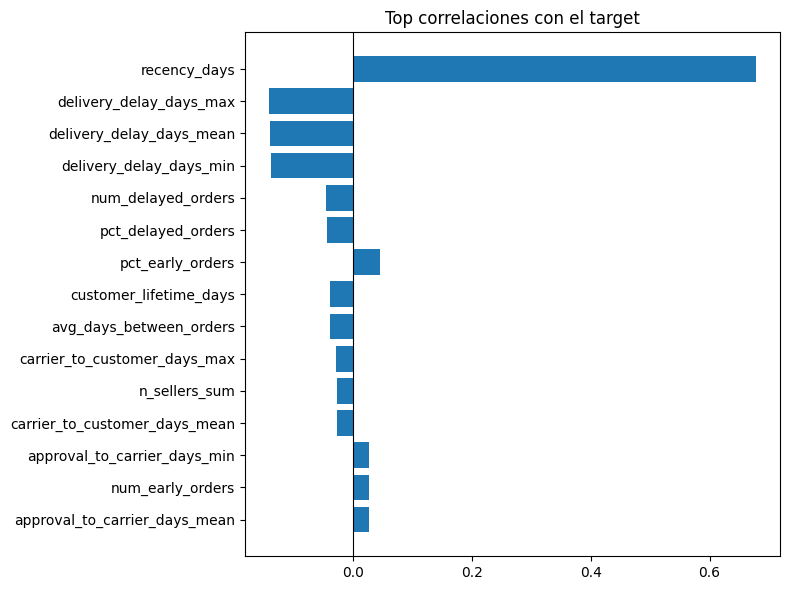

Shape de X, y: (81147, 94) (81147,)
Train / Test listos.


In [34]:

numeric_vars = [
    col for col in customer_features.select_dtypes(include=[np.number]).columns
    if col not in ['churn_prelim', 'churn_final']
]

corr_rows = []
for var in numeric_vars:
    corr = customer_features[[var, TARGET_COL]].corr().iloc[0, 1]
    corr_rows.append({'Variable': var, 'Correlation': corr, 'Abs': abs(corr)})

corr_df = (
    pd.DataFrame(corr_rows)
    .dropna()
    .sort_values('Abs', ascending=False)
)

print("Top 15 correlaciones (|corr|):")
for _, row in corr_df.head(15).iterrows():
    strength = "FUERTE" if abs(row['Correlation']) > 0.5 else                    "MODERADA" if abs(row['Correlation']) > 0.3 else "DÉBIL"
    print(f"  {row['Variable']:35s}: {row['Correlation']:+.3f} ({strength})")

top_corr = corr_df.head(15)
plt.figure(figsize=(8, 6))
plt.barh(top_corr['Variable'], top_corr['Correlation'])
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Top correlaciones con el target')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

feature_cols_numeric = numeric_vars
feature_cols_categ = ['customer_state']

X_num = customer_features[feature_cols_numeric].fillna(0)
X_cat = pd.get_dummies(customer_features[feature_cols_categ], drop_first=True)

X = pd.concat([X_num, X_cat], axis=1)
y = customer_features[TARGET_COL]

print("Shape de X, y:", X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train / Test listos.")


## 11. Modelos (Logistic Regression y Random Forest)

Reporte – Regresión Logística
              precision    recall  f1-score   support

           0      1.000     0.990     0.995     21324
           1      0.931     1.000     0.964      3021

    accuracy                          0.991     24345
   macro avg      0.966     0.995     0.980     24345
weighted avg      0.991     0.991     0.991     24345

ROC-AUC: 0.9999913691137589


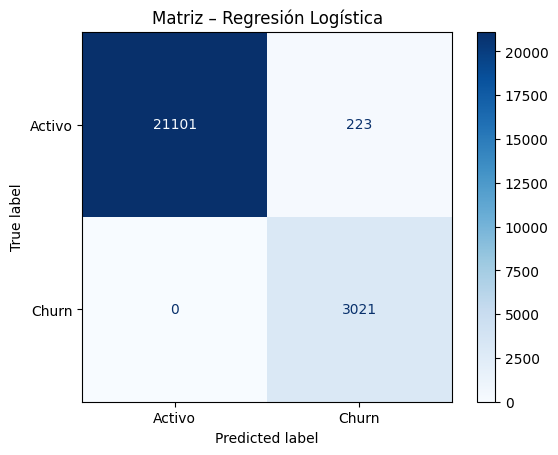

Reporte – Random Forest
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     21324
           1      1.000     1.000     1.000      3021

    accuracy                          1.000     24345
   macro avg      1.000     1.000     1.000     24345
weighted avg      1.000     1.000     1.000     24345

ROC-AUC: 1.0


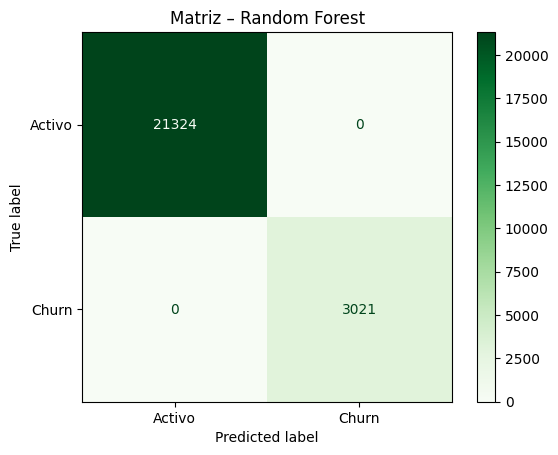


Top 20 variables más importantes (RF):


,importance
recency_days,0.6856
purchase_to_approval_days_max,0.0330
purchase_to_approval_days_mean,0.0308
purchase_to_approval_days_min,0.0287
delivery_delay_days_max,0.0205
delivery_delay_days_mean,0.0203
delivery_delay_days_min,0.0194
total_freight_value_mean,0.0120
total_freight_value_min,0.0117
total_freight_value_max,0.0108


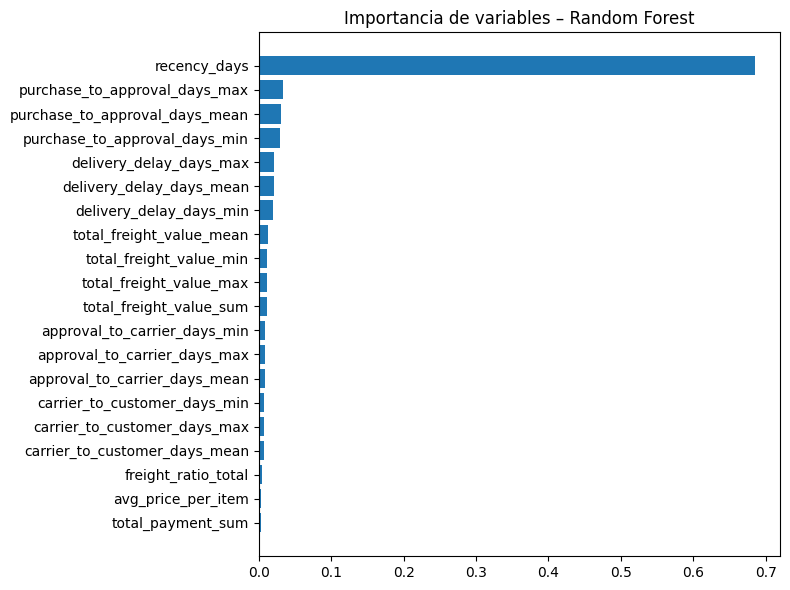

KPIs de modelado: {'roc_auc_lr': np.float64(0.9999913691137589), 'roc_auc_rf': np.float64(1.0)}


In [35]:

# Regresión Logística
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Reporte – Regresión Logística")
print(classification_report(y_test, y_pred_lr, digits=3))
roc_lr = roc_auc_score(y_test, y_proba_lr)
print("ROC-AUC:", roc_lr)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_lr,
    display_labels=['Activo', 'Churn'],
    cmap='Blues'
)
plt.title('Matriz – Regresión Logística')
plt.show()

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Reporte – Random Forest")
print(classification_report(y_test, y_pred_rf, digits=3))
roc_rf = roc_auc_score(y_test, y_proba_rf)
print("ROC-AUC:", roc_rf)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf,
    display_labels=['Activo', 'Churn'],
    cmap='Greens'
)
plt.title('Matriz – Random Forest')
plt.show()

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 20 variables más importantes (RF):")
display(importances.head(20).to_frame('importance'))

top_imp = importances.head(20)
plt.figure(figsize=(8, 6))
plt.barh(top_imp.index, top_imp.values)
plt.title('Importancia de variables – Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

kpis_modelado = {
    'roc_auc_lr': roc_lr,
    'roc_auc_rf': roc_rf
}
print("KPIs de modelado:", kpis_modelado)


## 12. Métricas de negocio y pruebas Chi² / ANOVA

In [36]:

X_num = customer_features[numeric_vars].fillna(0)
mm_scaler = MinMaxScaler()
X_chi2 = mm_scaler.fit_transform(X_num)

chi2_vals, chi2_p = chi2(X_chi2, y)
chi2_results = pd.DataFrame({
    'feature': numeric_vars,
    'chi2_stat': chi2_vals,
    'p_value': chi2_p
}).sort_values('p_value')

print("Top 10 variables (Chi²):")
display(chi2_results.head(10))

f_vals, f_p = f_classif(X_num, y)
f_results = pd.DataFrame({
    'feature': numeric_vars,
    'f_stat': f_vals,
    'p_value': f_p
}).sort_values('p_value')

print("\nTop 10 variables (ANOVA F-test):")
display(f_results.head(10))


Top 10 variables (Chi²):


,feature,chi2_stat,p_value
61,recency_days,"6,678.7169",0.0000
64,pct_delayed_orders,148.0472,0.0000
62,customer_lifetime_days,111.4499,0.0000
63,avg_days_between_orders,109.1164,0.0000
58,delivery_delay_days_max,101.5952,0.0000
55,delivery_delay_days_mean,99.7543,0.0000
57,delivery_delay_days_min,96.2579,0.0000
59,num_delayed_orders,53.2903,0.0000
37,avg_review_score_std,49.5970,0.0000
33,avg_installments_std,44.3485,0.0000



Top 10 variables (ANOVA F-test):


,feature,f_stat,p_value
57,delivery_delay_days_min,"1,578.1753",0.0000
55,delivery_delay_days_mean,"1,639.7942",0.0000
61,recency_days,"68,910.0990",0.0000
58,delivery_delay_days_max,"1,664.8134",0.0000
59,num_delayed_orders,172.1225,0.0000
64,pct_delayed_orders,163.4617,0.0000
65,pct_early_orders,162.9710,0.0000
62,customer_lifetime_days,128.3078,0.0000
63,avg_days_between_orders,126.0104,0.0000
54,carrier_to_customer_days_max,67.0600,0.0000


## 12.1 Selección automática de features basada en rankings (Corr, Chi², ANOVA, RF)

In [37]:
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

print("=== 12.1 Selección automática de features ===")

# Usamos el target final ya definido anteriormente
y_fs = customer_features['churn_final']

# Tomamos todas las columnas numéricas excepto las targets
numeric_cols_fs = [
    c for c in customer_features.select_dtypes(include=[np.number]).columns
    if c not in ['churn_prelim', 'churn_final']
]

X_num_fs = customer_features[numeric_cols_fs].copy()

# Imputación simple de nulos para este análisis
X_num_fs = X_num_fs.fillna(0)

# -------------------------------------------------------------------
# 1) Correlación con el target (para todas las numéricas)
# -------------------------------------------------------------------
corr_rows = []
for col in numeric_cols_fs:
    corr_val = customer_features[[col, 'churn_final']].corr().iloc[0, 1]
    corr_rows.append({
        'feature': col,
        'corr': corr_val,
        'abs_corr': abs(corr_val)
    })

corr_df = pd.DataFrame(corr_rows).sort_values('abs_corr', ascending=False)

print("\nTop 10 variables por |correlación| con churn_final:")
display(corr_df.head(10))

# -------------------------------------------------------------------
# 2) Chi² (requiere valores no negativos → escalamos a [0, 1])
# -------------------------------------------------------------------
scaler_mm = MinMaxScaler()
X_mm = scaler_mm.fit_transform(X_num_fs)

chi2_vals, chi2_p = chi2(X_mm, y_fs)

chi2_df = pd.DataFrame({
    'feature': numeric_cols_fs,
    'chi2_stat': chi2_vals,
    'p_value': chi2_p
}).sort_values('chi2_stat', ascending=False)

print("\nTop 10 variables por Chi²:")
display(chi2_df.head(10))

# -------------------------------------------------------------------
# 3) ANOVA F-test
# -------------------------------------------------------------------
f_vals, f_p = f_classif(X_num_fs, y_fs)

anova_df = pd.DataFrame({
    'feature': numeric_cols_fs,
    'f_stat': f_vals,
    'p_value': f_p
}).sort_values('f_stat', ascending=False)

print("\nTop 10 variables por ANOVA F-test:")
display(anova_df.head(10))

# -------------------------------------------------------------------
# 4) Importancias de Random Forest
# -------------------------------------------------------------------
rf_fs = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)
rf_fs.fit(X_num_fs, y_fs)

rf_importances_df = pd.DataFrame({
    'feature': numeric_cols_fs,
    'importance': rf_fs.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 variables por importancia del Random Forest:")
display(rf_importances_df.head(15))

# -------------------------------------------------------------------
# 5) Construir la lista final de features seleccionadas
#    (unión de tops de cada ranking, sin duplicados)
# -------------------------------------------------------------------
top_corr_features = corr_df.head(10)['feature'].tolist()
top_chi2_features = chi2_df.head(10)['feature'].tolist()
top_anova_features = anova_df.head(10)['feature'].tolist()
top_rf_features = rf_importances_df.head(15)['feature'].tolist()

selected_features = sorted(
    set(top_corr_features + top_chi2_features + top_anova_features + top_rf_features)
)

print("\nResumen de selección de features:")
print(f"  • Num. variables numéricas totales : {len(numeric_cols_fs)}")
print(f"  • Num. variables seleccionadas     : {len(selected_features)}")
print("  • Lista de features seleccionadas:")
print(selected_features)


=== 12.1 Selección automática de features ===

Top 10 variables por |correlación| con churn_final:


,feature,corr,abs_corr
61,recency_days,0.6777,0.6777
58,delivery_delay_days_max,-0.1418,0.1418
55,delivery_delay_days_mean,-0.1407,0.1407
57,delivery_delay_days_min,-0.1381,0.1381
59,num_delayed_orders,-0.0460,0.0460
64,pct_delayed_orders,-0.0448,0.0448
65,pct_early_orders,0.0448,0.0448
62,customer_lifetime_days,-0.0397,0.0397
63,avg_days_between_orders,-0.0394,0.0394
54,carrier_to_customer_days_max,-0.0287,0.0287



Top 10 variables por Chi²:


,feature,chi2_stat,p_value
61,recency_days,"6,678.7169",0.0000
64,pct_delayed_orders,148.0472,0.0000
62,customer_lifetime_days,111.4499,0.0000
63,avg_days_between_orders,109.1164,0.0000
58,delivery_delay_days_max,101.5952,0.0000
55,delivery_delay_days_mean,99.7543,0.0000
57,delivery_delay_days_min,96.2579,0.0000
59,num_delayed_orders,53.2903,0.0000
37,avg_review_score_std,49.5970,0.0000
33,avg_installments_std,44.3485,0.0000



Top 10 variables por ANOVA F-test:


,feature,f_stat,p_value
61,recency_days,"68,910.0990",0.0000
58,delivery_delay_days_max,"1,664.8134",0.0000
55,delivery_delay_days_mean,"1,639.7942",0.0000
57,delivery_delay_days_min,"1,578.1753",0.0000
59,num_delayed_orders,172.1225,0.0000
64,pct_delayed_orders,163.4617,0.0000
65,pct_early_orders,162.9710,0.0000
62,customer_lifetime_days,128.3078,0.0000
63,avg_days_between_orders,126.0104,0.0000
54,carrier_to_customer_days_max,67.0600,0.0000



Top 15 variables por importancia del Random Forest:


,feature,importance
61,recency_days,0.7351
46,purchase_to_approval_days_max,0.0334
43,purchase_to_approval_days_mean,0.0287
45,purchase_to_approval_days_min,0.0256
58,delivery_delay_days_max,0.0206
57,delivery_delay_days_min,0.0194
55,delivery_delay_days_mean,0.0173
15,total_freight_value_min,0.0103
12,total_freight_value_sum,0.0098
16,total_freight_value_max,0.0098



Resumen de selección de features:
  • Num. variables numéricas totales : 68
  • Num. variables seleccionadas     : 23
  • Lista de features seleccionadas:
['approval_to_carrier_days_max', 'approval_to_carrier_days_mean', 'approval_to_carrier_days_min', 'avg_days_between_orders', 'avg_installments_std', 'avg_review_score_std', 'carrier_to_customer_days_max', 'carrier_to_customer_days_mean', 'customer_lifetime_days', 'delivery_delay_days_max', 'delivery_delay_days_mean', 'delivery_delay_days_min', 'num_delayed_orders', 'pct_delayed_orders', 'pct_early_orders', 'purchase_to_approval_days_max', 'purchase_to_approval_days_mean', 'purchase_to_approval_days_min', 'recency_days', 'total_freight_value_max', 'total_freight_value_mean', 'total_freight_value_min', 'total_freight_value_sum']


## 12.2 Modelo reducido con features seleccionadas y comparación con modelo full

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

print("=== 12.2 Modelo reducido (Logistic Regression) ===")

# Target final
y = customer_features['churn_final']

# -----------------------------
# Construcción de X_full
# -----------------------------
numeric_cols_full = [
    c for c in customer_features.select_dtypes(include=[np.number]).columns
    if c not in ['churn_prelim', 'churn_final']
]
X_num_full = customer_features[numeric_cols_full].fillna(0)

X_cat = pd.get_dummies(customer_features[['customer_state']], drop_first=True)

X_full = pd.concat([X_num_full, X_cat], axis=1)

# -----------------------------
# Construcción de X_reduced
# (solo las features seleccionadas + mismas dummies de estado)
# -----------------------------
numeric_cols_reduced = [f for f in selected_features if f in numeric_cols_full]

X_num_reduced = customer_features[numeric_cols_reduced].fillna(0)
X_reduced = pd.concat([X_num_reduced, X_cat], axis=1)

print(f"Dimensión X_full    : {X_full.shape}")
print(f"Dimensión X_reduced : {X_reduced.shape}")

# -----------------------------
# Misma partición train/test para ambos modelos
# -----------------------------
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Alineamos X_reduced con los mismos índices
X_train_reduced = X_reduced.loc[X_train_full.index]
X_test_reduced = X_reduced.loc[X_test_full.index]

# -----------------------------
# Modelo FULL (todas las features)
# -----------------------------
scaler_full = StandardScaler()
X_train_full_s = scaler_full.fit_transform(X_train_full)
X_test_full_s = scaler_full.transform(X_test_full)

lr_full = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_full.fit(X_train_full_s, y_train)

y_prob_full = lr_full.predict_proba(X_test_full_s)[:, 1]
y_pred_full = lr_full.predict(X_test_full_s)

acc_full = accuracy_score(y_test, y_pred_full)
f1_full = f1_score(y_test, y_pred_full, pos_label=1)
auc_full = roc_auc_score(y_test, y_prob_full)

# -----------------------------
# Modelo REDUCIDO (features seleccionadas)
# -----------------------------
scaler_red = StandardScaler()
X_train_red_s = scaler_red.fit_transform(X_train_reduced)
X_test_red_s = scaler_red.transform(X_test_reduced)

lr_red = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_red.fit(X_train_red_s, y_train)

y_prob_red = lr_red.predict_proba(X_test_red_s)[:, 1]
y_pred_red = lr_red.predict(X_test_red_s)

acc_red = accuracy_score(y_test, y_pred_red)
f1_red = f1_score(y_test, y_pred_red, pos_label=1)
auc_red = roc_auc_score(y_test, y_prob_red)

# -----------------------------
# Comparación de métricas
# -----------------------------
print("\nComparación de métricas (Logistic Regression):")
print(f"  Modelo FULL    -> acc: {acc_full:.4f} | f1_churn: {f1_full:.4f} | AUC: {auc_full:.6f}")
print(f"  Modelo REDUCIDO-> acc: {acc_red:.4f} | f1_churn: {f1_red:.4f} | AUC: {auc_red:.6f}")

print("\nConclusión:")
if abs(auc_full - auc_red) < 0.005:
    print("  • El modelo reducido mantiene prácticamente el mismo desempeño que el modelo full,")
    print("    con menos variables (más simple de explicar y mantener).")
else:
    print("  • El modelo reducido pierde algo de desempeño frente al modelo full;")
    print("    se debe evaluar si la simplicidad compensa esa pérdida.")

=== 12.2 Modelo reducido (Logistic Regression) ===
Dimensión X_full    : (81147, 94)
Dimensión X_reduced : (81147, 49)

Comparación de métricas (Logistic Regression):
  Modelo FULL    -> acc: 0.9908 | f1_churn: 0.9644 | AUC: 0.999991
  Modelo REDUCIDO-> acc: 0.9908 | f1_churn: 0.9641 | AUC: 0.999996

Conclusión:
  • El modelo reducido mantiene prácticamente el mismo desempeño que el modelo full,
    con menos variables (más simple de explicar y mantener).


## 13. Función `run_monthly_pipeline()` y persistencia de snapshots

In [39]:
def run_monthly_pipeline(
    periodo_objetivo: str,
    data_raw: dict,
    processed_dir: Path
):
    """
    Ejecuta el pipeline completo para un período YYYY-MM:
      - Filtra datos hasta FECHA_CORTE.
      - Construye orders_enriched y customer_features.
      - Aplica limpieza avanzada (imputación + outliers).
      - Define churn_prelim y churn_final usando los umbrales calculados.
      - Entrena LR y RF para obtener ROC-AUC del período.
      - Guarda snapshots (master, features) y actualiza KPIs históricos.
    """
    periodo = pd.Period(periodo_objetivo, freq='M')
    fecha_corte = periodo.to_timestamp('M')
    print(f"=== Pipeline para {periodo_objetivo} (corte {fecha_corte.date()}) ===")

    # Evitar reprocesar meses ya corridos
    last_period = get_last_processed_period(processed_dir / 'features')
    if last_period is not None and periodo_objetivo <= last_period:
        raise ValueError(f"Período {periodo_objetivo} ya procesado o anterior ({last_period}).")

    # 1) Corte de datos crudos al FECHA_CORTE
    data_cut = cut_data_to_fecha_corte(data_raw, fecha_corte)

    # 2) Tabla enriquecida de órdenes
    orders_enriched = build_orders_enriched(
        data_cut['orders'],
        data_cut['customers'],
        data_cut['order_items'],
        data_cut['order_payments'],
        data_cut['order_reviews']
    )

    # 3) Features por cliente
    customer_features = build_customer_features(orders_enriched, fecha_corte)

    # 4) Limpieza avanzada (imputación + outliers)
    customer_features = clean_customer_features(customer_features)

    # 5) Targets usando los umbrales calculados previamente
    customer_features['churn_prelim'] = (
        customer_features['recency_days'] > CHURN_PRELIM_THRESHOLD
    ).astype(int)

    customer_features['churn_final'] = (
        customer_features['recency_days'] > CHURN_FINAL_THRESHOLD
    ).astype(int)

    # 6) KPIs de negocio
    kpis = compute_basic_kpis(customer_features, 'churn_final')

    # 7) Modelos del período (misma lógica que en el bloque de modelos base)
    numeric_vars_local = [
        col for col in customer_features.select_dtypes(include=[np.number]).columns
        if col not in ['churn_prelim', 'churn_final']
    ]
    X_num = customer_features[numeric_vars_local].fillna(0)
    X_cat = pd.get_dummies(customer_features[['customer_state']], drop_first=True)
    X_local = pd.concat([X_num, X_cat], axis=1)
    y_local = customer_features['churn_final']

    X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
        X_local, y_local, test_size=0.3, random_state=42, stratify=y_local
    )

    scaler_l = StandardScaler()
    X_train_ls = scaler_l.fit_transform(X_train_l)
    X_test_ls = scaler_l.transform(X_test_l)

    lr_l = LogisticRegression(max_iter=1000, class_weight='balanced')
    lr_l.fit(X_train_ls, y_train_l)
    roc_lr_l = roc_auc_score(y_test_l, lr_l.predict_proba(X_test_ls)[:, 1])

    rf_l = RandomForestClassifier(
        n_estimators=200, max_depth=None, random_state=42, class_weight='balanced'
    )
    rf_l.fit(X_train_l, y_train_l)
    roc_rf_l = roc_auc_score(y_test_l, rf_l.predict_proba(X_test_l)[:, 1])

    # 8) Guardar snapshots (master y features)
    master_path = processed_dir / 'master' / f"orders_enriched_{periodo_objetivo}.parquet"
    features_path = processed_dir / 'features' / f"customer_features_{periodo_objetivo}.parquet"

    orders_enriched.to_parquet(master_path, index=False)
    customer_features.to_parquet(features_path, index=False)

    print("Guardado:")
    print(" -", master_path)
    print(" -", features_path)

    # 9) Actualizar histórico de KPIs (negocio + modelos)
    kpis_row = {
        'periodo': periodo_objetivo,
        'fecha_corte': fecha_corte.date(),
        'clientes_totales': kpis['clientes_totales'],
        'clientes_churn': kpis['clientes_churn'],
        'clientes_activos': kpis['clientes_activos'],
        'churn_rate': kpis['churn_rate'],
        'retention_rate': kpis['retention_rate'],
        'avg_monetary_total': kpis['avg_monetary_total'],
        'avg_monetary_activos': kpis['avg_monetary_activos'],
        'avg_monetary_churn': kpis['avg_monetary_churn'],
        'roc_auc_lr': float(roc_lr_l),
        'roc_auc_rf': float(roc_rf_l)
    }

    metrics_dir = processed_dir / 'metrics'
    kpis_file = metrics_dir / "kpis_churn_history.csv"
    if kpis_file.exists():
        kpis_hist = pd.read_csv(kpis_file)
        kpis_hist = pd.concat([kpis_hist, pd.DataFrame([kpis_row])], ignore_index=True)
    else:
        kpis_hist = pd.DataFrame([kpis_row])
    kpis_hist.to_csv(kpis_file, index=False)
    print("KPIs actualizados en:", kpis_file)

    return {
        'orders_enriched': orders_enriched,
        'customer_features': customer_features,
        'kpis': kpis_row
    }

# Ejecutar el pipeline para el período definido en PERIODO_OBJETIVO
results_periodo = run_monthly_pipeline(PERIODO_OBJETIVO, data, PROCESSED_DIR)

print("\nResumen de KPIs del período:")
for k, v in results_periodo['kpis'].items():
    print(f"  {k}: {v}")

=== Pipeline para 2018-06 (corte 2018-06-30) ===
Número total de variables (columnas): 72

[Clean] Resumen de limpieza avanzada de customer_features
  • Nulos numéricos antes : 947607
  • Nulos numéricos después: 0
  • Valores recortados por abajo (p1) : 28395
  • Valores recortados por arriba (p99): 37768
KPIs de negocio (con target churn_final):
  • Churn rate      : 12.41%
  • Retention rate  : 87.59%
  • Gasto promedio total  : 159.06
  • Gasto promedio activos: 159.03
  • Gasto promedio churn  : 159.29
Guardado:
 - /content/drive/MyDrive/Maestria/M13/Olist/processed/master/orders_enriched_2018-06.parquet
 - /content/drive/MyDrive/Maestria/M13/Olist/processed/features/customer_features_2018-06.parquet
KPIs actualizados en: /content/drive/MyDrive/Maestria/M13/Olist/processed/metrics/kpis_churn_history.csv

Resumen de KPIs del período:
  periodo: 2018-06
  fecha_corte: 2018-06-30
  clientes_totales: 81147
  clientes_churn: 10070
  clientes_activos: 71077
  churn_rate: 0.1240957768001

## 13.1 Simulamos la corrida a un mes adicional (2018-07)

In [40]:
results_2018_07 = run_monthly_pipeline("2018-07", data, PROCESSED_DIR)

=== Pipeline para 2018-07 (corte 2018-07-31) ===
Número total de variables (columnas): 72

[Clean] Resumen de limpieza avanzada de customer_features
  • Nulos numéricos antes : 1014624
  • Nulos numéricos después: 0
  • Valores recortados por abajo (p1) : 30479
  • Valores recortados por arriba (p99): 40405
KPIs de negocio (con target churn_final):
  • Churn rate      : 15.15%
  • Retention rate  : 84.85%
  • Gasto promedio total  : 159.43
  • Gasto promedio activos: 159.70
  • Gasto promedio churn  : 157.93
Guardado:
 - /content/drive/MyDrive/Maestria/M13/Olist/processed/master/orders_enriched_2018-07.parquet
 - /content/drive/MyDrive/Maestria/M13/Olist/processed/features/customer_features_2018-07.parquet
KPIs actualizados en: /content/drive/MyDrive/Maestria/M13/Olist/processed/metrics/kpis_churn_history.csv


## 13.1 Simulamos la corrida a un mes adicional (2018-08)

In [42]:
results_2018_07 = run_monthly_pipeline("2018-08", data, PROCESSED_DIR)

=== Pipeline para 2018-08 (corte 2018-08-31) ===
Número total de variables (columnas): 72

[Clean] Resumen de limpieza avanzada de customer_features
  • Nulos numéricos antes : 1089879
  • Nulos numéricos después: 0
  • Valores recortados por abajo (p1) : 32660
  • Valores recortados por arriba (p99): 43282
KPIs de negocio (con target churn_final):
  • Churn rate      : 17.99%
  • Retention rate  : 82.01%
  • Gasto promedio total  : 159.08
  • Gasto promedio activos: 159.76
  • Gasto promedio churn  : 155.97
Guardado:
 - /content/drive/MyDrive/Maestria/M13/Olist/processed/master/orders_enriched_2018-08.parquet
 - /content/drive/MyDrive/Maestria/M13/Olist/processed/features/customer_features_2018-08.parquet
KPIs actualizados en: /content/drive/MyDrive/Maestria/M13/Olist/processed/metrics/kpis_churn_history.csv



## 14. Notas para Git y storytelling

- Versionar este notebook en Git junto con:
  - README con descripción del problema, datos y pipeline.
  - Diagrama simple del flujo mensual (ingesta → features → modelo → KPIs).
- Para la exposición (15 minutos):
  - Explicar el **problema de negocio** y el costo del churn.
  - Mostrar **cómo se construyen las features** (RFM, logística, valor).
  - Resumir **target final** y **churn rate**.
  - Presentar **importancia de variables** (RF) y **métricas** (recall, ROC-AUC).
  - Cerrar con cómo el pipeline se puede correr **cada mes** para actualizar alarmas de clientes en riesgo.


## 666. Reset de snapshots del pipeline (borrar resultados previos)

In [43]:
from pathlib import Path

def reset_processed_outputs(processed_dir: Path):
    """Elimina los archivos generados por el pipeline (snapshots), sin tocar los datos crudos."""
    master_dir = processed_dir / 'master'
    features_dir = processed_dir / 'features'
    metrics_dir = processed_dir / 'metrics'

    deleted_master = 0
    deleted_features = 0
    deleted_metrics = 0

    # Borrar Parquet de master
    if master_dir.exists():
        for f in master_dir.glob('*.parquet'):
            f.unlink()
            deleted_master += 1

    # Borrar Parquet de features
    if features_dir.exists():
        for f in features_dir.glob('*.parquet'):
            f.unlink()
            deleted_features += 1

    # Borrar CSV de KPIs
    if metrics_dir.exists():
        for f in metrics_dir.glob('*.csv'):
            f.unlink()
            deleted_metrics += 1

    print("Reset de snapshots completado:")
    print(f"  • Archivos master   eliminados: {deleted_master}")
    print(f"  • Archivos features eliminados: {deleted_features}")
    print(f"  • Archivos metrics  eliminados: {deleted_metrics}")

# Ejecutar reset (OPCIONAL; solo cuando quieras volver a empezar desde cero)
# reset_processed_outputs(PROCESSED_DIR)